# BeamNGpy multishot camera
*BeamNG.tech only*

This example shows how to change the properties of the camera sensor to render images from multiple perspective to emulate a multishot camera.

## Setup

This example will spawn a vehicle on the smallgrid map and have the camera take an image from the front and vary the position of the camera both horizontally and vertically, always pointing at the vehicle's center.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from beamngpy import BeamNGpy, Scenario, Vehicle
from beamngpy.sensors import Camera
from time import sleep

def get_bounding_box_center(bbox):
    rbl = np.array(bbox['rear_bottom_left'])
    fbr = np.array(bbox['front_bottom_right'])
    rtl = np.array(bbox['rear_top_left'])
    center = rbl + ((fbr - rbl) / 2) + ((rtl - rbl) / 2)
    return center

def rotate(vec, h, v):
    rot_x = np.cos(h) * vec[0] - np.sin(h) * vec[1]
    rot_y = np.sin(h) * vec[0] + np.cos(h) * vec[1]
    rot_z = np.sin(v) * rot_y + np.cos(v) * vec[2]
    return np.array([rot_x, rot_y, rot_z])

# Start the simulator.
beamng = BeamNGpy('localhost', 64256)
beamng.open()

# Create a vehicle.
vehicle = Vehicle('ego_vehicle', model='etki', license='PYTHON', color='Green')

# Create a scenario.
scenario = Scenario('smallgrid', 'multishot', description='Demo of the camera sensor used like a multishot camera')
scenario.add_vehicle(vehicle)
scenario.make(beamng)
beamng.scenario.load(scenario)
beamng.scenario.start()

camera = Camera('camera1', beamng, vehicle)                     # Create a default camera sensor, attached to the vehicle.

center = get_bounding_box_center(vehicle.get_bbox())
center[1] -= 0.75                                               # An offset to move center back a bit to get more of the vehicle.
pos_offset = center + np.array([3.5, 0, 0])                     # An offset to move the camera a few metres in front of the center.

variations = [np.radians(a) for a in [-10, 0, 10]]

## Running

Once BeamNG.tech has been started and the scenario loaded, we will pivot the camera around the vehicle on the horizontal and vertical axis by -15, 0, +15 degrees each, leading to 9 images in total.

In [2]:
images = []
for h in variations:
    image_row = []
    for v in variations:
        new_pos = rotate(pos_offset, h, v)                      # Set a new position and direction for the camera.
        camera.set_position((new_pos[0], new_pos[1], new_pos[2]))
        dir = center - new_pos
        camera.set_direction((dir[0], dir[1], dir[2]))

        sleep(0.3)                                              # A slight delay to allow the automated camera to get fresh readings.

        data = camera.poll()                                    # Get the latest image data from the camera.

        image = data['colour']                                  # colour image.
        #image = data['annotation']                             # use this instead for the annotation image.
        #image = data['depth']                                  # use this instead for the depth image.
        image_row.append(image)

    images.append(image_row)

## Plotting

With images collected, we will now set up a simple 3x3 plot to show the 9 angle variations.

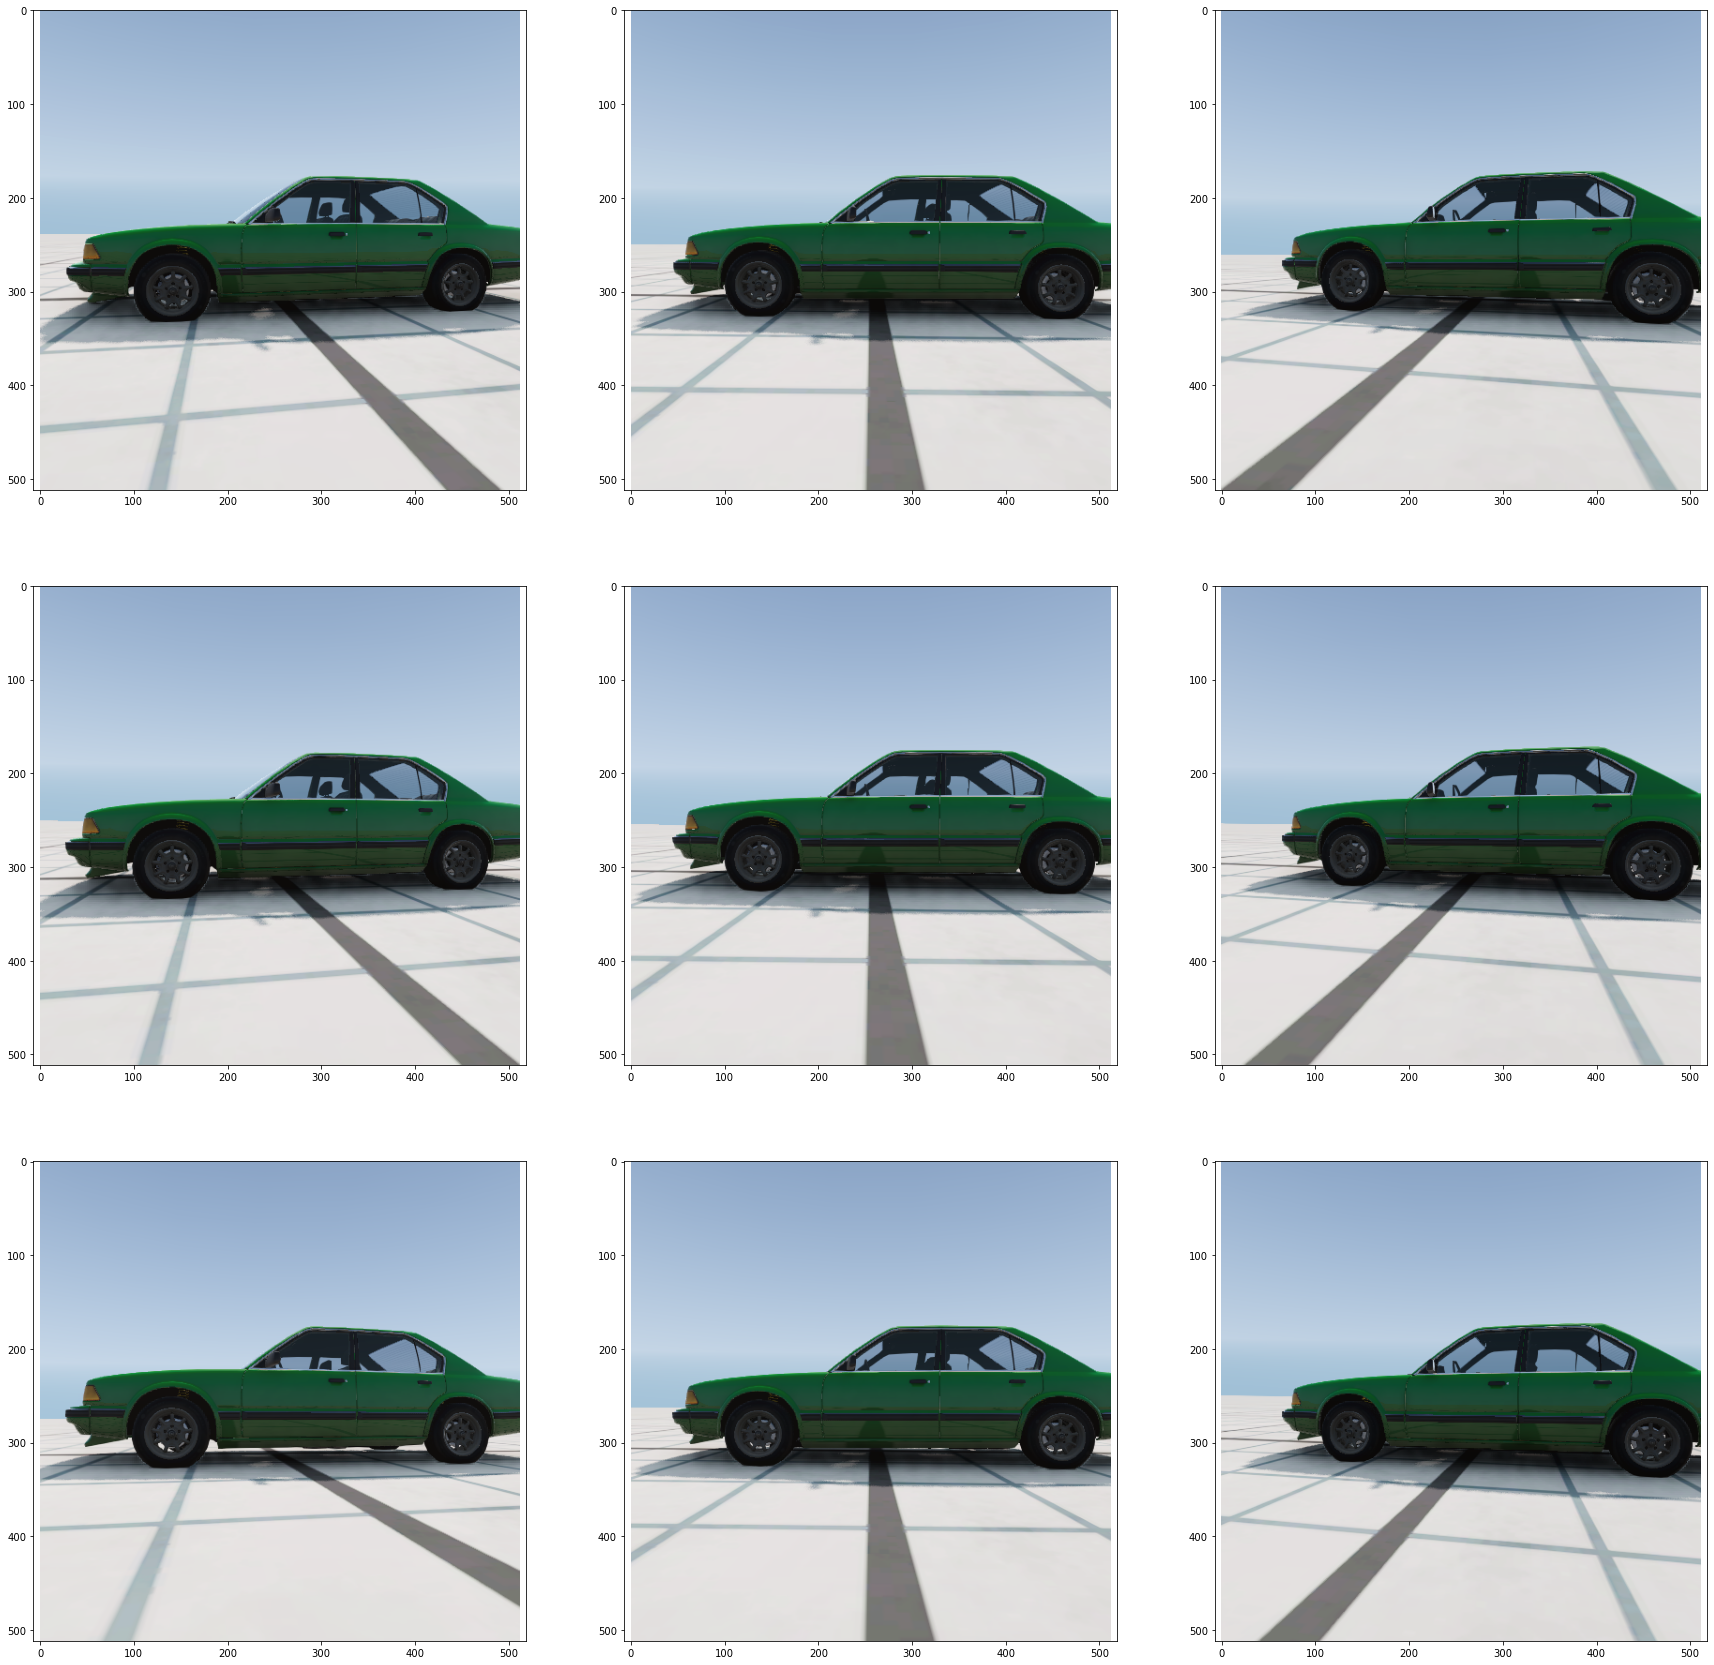

In [3]:
# Plot the images.
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
for x, row in enumerate(images):
    for y, image in enumerate(row):
        ax[y, x].imshow(np.asarray(image.convert('RGB')))
        ax[y, x].set_aspect('equal', 'datalim')
plt.show()

# Tidy up and close the simulation.
camera.remove()
beamng.close()